<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%96%89%EC%82%AC%20%EC%B0%B8%EC%97%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%EC%9D%84%20%ED%86%B5%ED%95%9C%20%EC%95%88%EC%A0%84%20%EA%B4%80%EB%A6%AC%20%EC%BB%A8%EC%84%A4%ED%8C%85%20%EC%84%9C%EB%B9%84%EC%8A%A4/0903%20%ED%96%89%EC%82%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%20%EB%AA%A8%EB%8D%B8%20%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#### 공연벡터화 모델 사용

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DAB/Model /공연정보2.csv', encoding = 'cp949')
df = df.fillna(' ')

In [ ]:
def get_months_in_range(date_range):
    start_date, end_date = date_range.split(' ~ ')
    start_year, start_month, _ = map(int, start_date.split('.'))
    end_year, end_month, _ = map(int, end_date.split('.'))

    months = []
    current_year = start_year
    current_month = start_month

    while current_year < end_year or (current_year == end_year and current_month <= end_month):
        month_name = str(current_month) + '월'
        months.append(month_name)

        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

    return months

In [ ]:
df['년도'] = 0
for i in range(len(df)):
  df['년도'].iloc[i] = df['일시'].iloc[i][0:4] + '년'

<ipython-input-10-fed1ca671a4c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['년도'].iloc[i] = df['일시'].iloc[i][0:4] + '년'


In [ ]:
df['월'] = 0
for i in range(len(df)):
    try:
      months_in_range = get_months_in_range(df['일시'].iloc[i])
      df['월'].iloc[i] = months_in_range
      df['월'].iloc[i] = ', '.join(df['월'].iloc[i])
    except: continue

<ipython-input-11-b1e9561dbbb5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['월'].iloc[i] = months_in_range


In [ ]:
df['월'] = df['월'].astype(str)
df['텍스트'] = 0
df['텍스트'] = df['이름'] + ' ' + df['세부장르'] + ' ' + df['장소'] + ' ' + df['출연']  + ' ' + df['Staff'] + ' ' + df['년도'] + ' ' + df['월'] + df['행사 종류']

In [ ]:
df['인덱스'] = 0
for i in range(len(df)):
    df['인덱스'].iloc[i] = i

<ipython-input-13-d33237617c4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인덱스'].iloc[i] = i


In [ ]:
!pip install --upgrade gensim

In [ ]:
from gensim.utils import simple_preprocess
import nltk
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

In [ ]:
df['텍스트'] = [item.replace(',', ' ') for item in df['텍스트']]
df['텍스트'] = [item.replace('/', ' ') for item in df['텍스트']]
df['텍스트'] = [item.replace('-', ' ') for item in df['텍스트']]
df['텍스트'] = [item.replace('(', ' ') for item in df['텍스트']]
df['텍스트'] = [item.replace(')', ' ') for item in df['텍스트']]
df['텍스트'] = [item.replace('&', ' ') for item in df['텍스트']]
df['텍스트'] = [item.replace('!', ' ') for item in df['텍스트']]

In [ ]:
for i in range(len(df)):
    # 공백을 기준으로 문장을 단어로 분리하여 리스트로 만듭니다
    words = re.split(r'\s+', df['텍스트'].iloc[i].strip())
    df['텍스트'].iloc[i] = words

<ipython-input-17-dc8840a4d8e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['텍스트'].iloc[i] = words


In [ ]:
doc_df = df[['인덱스','텍스트']].values.tolist()
tagged_data = [TaggedDocument(words=_d, tags=[uid]) for uid, _d in doc_df]

In [ ]:
model2 = Doc2Vec.load('/content/drive/MyDrive/DAB/Model /show.model')

In [ ]:
import re
from gensim.models import Doc2Vec

model2.random.seed(42)

In [ ]:
def get_sentence_vector(sentence):
    table = str.maketrans(',/-()[＂]&!', '          ')
    sentence = sentence.translate(table)
    words = re.split(r'\s+', sentence.strip())
    vector = model2.infer_vector(doc_words=words)

    return vector

In [ ]:
# 벡터기반 유사공연 도출

def makesimilar(index):
  similar_doc = model2.docvecs.most_similar(index)
  first_elements = [element[0] for element in similar_doc]
  score = [element[1] for element in similar_doc]
  Similar = pd.DataFrame(columns = ['이름', '세부장르', '일시', '장소', '출연', 'Staff', '년도', '월', '텍스트', '인덱스'])

  for element in first_elements:
   A = df[df['인덱스'] == element]
   Similar = pd.concat([Similar, A])
  Similar['유사도'] = score
  Similar = Similar[['이름', '행사 종류' ,'세부장르','일시','장소','출연','Staff','유사도']]
  print(df.iloc[index])
  return(Similar)

In [ ]:
def get_sentence_vector(sentence):
    table = str.maketrans(',/-()[＂]&!', '          ')
    sentence = sentence.translate(table)
    words = re.split(r'\s+', sentence.strip())
    vector = model2.infer_vector(words)
    return vector

#### vector3 생성

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DAB/Model /Olympic_rent_2012.csv', encoding='cp949')

In [ ]:
def get_months_in_range(date_range):
    start_date, end_date = date_range.split(' ~ ')
    start_year, start_month, _ = map(int, start_date.split('-'))
    end_year, end_month, _ = map(int, end_date.split('-'))

    months = []
    current_year = start_year
    current_month = start_month

    while current_year < end_year or (current_year == end_year and current_month <= end_month):
        month_name = str(current_month) + '월'
        months.append(month_name)

        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

    return months

In [ ]:
from scipy.stats import t

def calculate_prediction_interval(data, alpha):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)

    df = n - 1

    # Calculate critical value (two-tailed)
    t_critical = t.ppf(1 - alpha / 2, df)

    # Calculate standard error
    std_error = std_dev / np.sqrt(n)

    # Calculate margin of error
    margin_of_error = t_critical * std_error

    # Calculate lower and upper bounds
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return lower_bound, upper_bound

confidence_level = 0.95

In [ ]:
df2['년도'] = 0
for i in range(len(df2)):
  df2['년도'].iloc[i] = df2['RENTLSPCE_BEGIN_DE'].iloc[i][0:4] + '년'

df2['일시'] = df2['RENTLSPCE_BEGIN_DE'] + ' ~ ' + df2['RENTLSPCE_END_DE']
df2['일시']

df2['월'] = 0
for i in range(len(df)):
    try:
      months_in_range = get_months_in_range(df2['일시'].iloc[i])
      df2['월'].iloc[i] = months_in_range
      df2['월'].iloc[i] = ', '.join(df2['월'].iloc[i])
    except: continue

<ipython-input-28-9bcdd66f12d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['년도'].iloc[i] = df2['RENTLSPCE_BEGIN_DE'].iloc[i][0:4] + '년'
<ipython-input-28-9bcdd66f12d6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['월'].iloc[i] = months_in_range


In [ ]:
df2['텍스트'] = df2['FCLTY_NM'] + ' ' + df2['EVENT_SDIV_NM'] + ' ' + df2['EVENT_NM'] + ' ' + df2['ISE_ELSE_FLAG_NM'] + ' ' + df2['년도'] + ' ' + df2['월']

In [ ]:
df2 = df2.reset_index(drop=True)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model2.random.seed(42)

In [ ]:
# 올림픽공원 유사공연 추출함수 vector3

def vector3(index,n):

  target_vector = get_sentence_vector(df2['텍스트'].iloc[index])

  df3 = df2[df2['RENTLSPCE_END_DE'] < df2['RENTLSPCE_BEGIN_DE'][index]]

  Vector = []
  for i in range(len(df3)):
     Vector.append(get_sentence_vector(df3['텍스트'].iloc[i]))

  similarities = cosine_similarity([target_vector], Vector)[0]

  most_similar_indices = np.argsort(similarities)[::-1][:n]

  return(df3.iloc[most_similar_indices])

#### Model1 (평균사용)

In [ ]:
def makeprediction1(index, a, b):
  data = []
  for i in range(a):
   vector2 = vector3(index,b)['EXCCLC_EVENT_NMPR_CO']
   data.append(vector2.mean())
  lower, upper = calculate_prediction_interval(data, confidence_level)
  return( (lower + upper)/2 )

In [ ]:
def calculate_mse1(i):
    try:
        actual = df2.iloc[i]['EXCCLC_EVENT_NMPR_CO']
        predict = makeprediction1(i, 15, 5)
        return (actual - predict) ** 2
    except:
        return 0

In [ ]:
# 계산 오래 걸림.
import multiprocessing
from tqdm import tqdm

num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_processes)

mse_list = list(
    tqdm(
        pool.imap(calculate_mse1, range(len(df2))),
        total=len(df2),
        desc="Calculating MSE1",
    )
)

mse = sum(mse_list)
print(mse)

In [ ]:
mse/len(df2)
#mse = 496292746911.43994

#### 변수선택

##### 전처리

In [ ]:
df2["FCLTY_NM"].value_counts()

올림픽홀                492
KSPO DOME(체조경기장)    299
핸드볼경기장              281
우리금융아트홀             122
뮤즈라이브               114
K-아트홀                80
평화의광장                56
88잔디마당               51
88호수수변무대             43
올림픽컨벤션센터             29
핸드볼보조경기장             21
기타                   18
피크닉광장                18
한얼광장                 16
우리금융아트홀 연습실          16
벨로드롬                  8
몽촌해자수변무대A             7
올림픽수영장                7
만남의광장                 5
몽촌해자수변무대B             3
촬영                    1
Name: FCLTY_NM, dtype: int64

In [ ]:
# 공연장소
df2.loc[df2["FCLTY_NM"] == "올림픽홀","FCLTY_NM"] = 1
df2.loc[df2["FCLTY_NM"] == "KSPO DOME(체조경기장)","FCLTY_NM"] = 2
df2.loc[df2["FCLTY_NM"] == "핸드볼경기장","FCLTY_NM"] = 3
df2.loc[df2["FCLTY_NM"] == "우리금융아트홀","FCLTY_NM"] = 4
df2.loc[df2["FCLTY_NM"] == "뮤즈라이브","FCLTY_NM"] = 5
df2.loc[df2["FCLTY_NM"] == "K-아트홀","FCLTY_NM"] = 6
df2.loc[df2["FCLTY_NM"] == "평화의광장","FCLTY_NM"] = 7
df2.loc[df2["FCLTY_NM"] == "88잔디마당","FCLTY_NM"] = 8
df2.loc[df2["FCLTY_NM"] == "88호수수변무대","FCLTY_NM"] = 9
df2.loc[df2["FCLTY_NM"] == "올림픽컨벤션센터","FCLTY_NM"] = 10
df2.loc[df2["FCLTY_NM"] == "핸드볼보조경기장","FCLTY_NM"] = 11
df2.loc[df2["FCLTY_NM"] == "기타","FCLTY_NM"] = 12
df2.loc[df2["FCLTY_NM"] == "피크닉광장","FCLTY_NM"] = 13
df2.loc[df2["FCLTY_NM"] == "한얼광장","FCLTY_NM"] = 14
df2.loc[df2["FCLTY_NM"] == "우리금융아트홀 연습실","FCLTY_NM"] = 15
df2.loc[df2["FCLTY_NM"] == "벨로드롬","FCLTY_NM"] = 16
df2.loc[df2["FCLTY_NM"] == "몽촌해자수변무대A","FCLTY_NM"] = 17
df2.loc[df2["FCLTY_NM"] == "올림픽수영장","FCLTY_NM"] = 18
df2.loc[df2["FCLTY_NM"] == "만남의광장","FCLTY_NM"] = 19
df2.loc[df2["FCLTY_NM"] == "몽촌해자수변무대B","FCLTY_NM"] = 20
df2.loc[df2["FCLTY_NM"] == "촬영","FCLTY_NM"] = 21

In [ ]:
# 문화예술행사 (1), 대중공연 (2), 체육행사 (3), 공공행사 (4), 순수예술공연 (5) (dummy variable)
df2.loc[df2["EVENT_SDIV_NM"] == "문화예술행사","EVENT_SDIV_NM"] = 1
df2.loc[df2["EVENT_SDIV_NM"] == "대중공연","EVENT_SDIV_NM"] = 2
df2.loc[df2["EVENT_SDIV_NM"] == "체육행사","EVENT_SDIV_NM"] = 3
df2.loc[df2["EVENT_SDIV_NM"] == "공공행사","EVENT_SDIV_NM"] = 4
df2.loc[df2["EVENT_SDIV_NM"] == "순수예술공연","EVENT_SDIV_NM"] = 5

In [ ]:
# 내부 (0), 외부 (1)로 코딩 (dummy variable)
df2.loc[df2["ISE_ELSE_FLAG_NM"] == "내부","ISE_ELSE_FLAG_NM"] = 0
df2.loc[df2["ISE_ELSE_FLAG_NM"] == "외부","ISE_ELSE_FLAG_NM"] = 1

In [ ]:
# 년도에서 숫자만 출력
df2['년도'] = df2['년도'].str.extract(r'(\d+)')

In [ ]:
# 월에서 숫자만 출력
df2['월'] = df2['월'].str.extract(r'(\d+)')

In [ ]:
df2 = df2.astype({'FCLTY_NM':'int','EVENT_SDIV_NM':'int','ISE_ELSE_FLAG_NM':'int','년도':'int','월':'int'})

##### 회귀분석

In [ ]:
#train & test set 분할
from sklearn.model_selection import train_test_split

y = df2['EXCCLC_EVENT_NMPR_CO']
X = df2.iloc[:,[0,1,5,7,8,9,11]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 1)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1180, 7) (507, 7) (1180,) (507,)


In [ ]:
train_set = X_train.copy()
train_set["EXCCLC_EVENT_NMPR_CO"] = y_train

In [ ]:
train_set

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,년도,월,EXCCLC_EVENT_NMPR_CO
462,2,1,29000,0,17,2014,4,29137
764,1,2,3500,0,2,2016,2,3000
538,3,4,1300,0,1,2014,11,1200
215,9,1,1000,1,4,2012,6,2057
1079,4,2,800,0,2,2018,3,688
...,...,...,...,...,...,...,...,...
715,7,4,2000,1,1,2015,10,2000
905,5,1,450,0,3,2016,12,340
1096,3,3,1000,0,4,2018,4,600
235,1,2,5400,0,4,2012,8,4200


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
corr = X.corr(method = 'pearson')
corr #신청인원, 사용일수 외에는 범주형 변수이기에 상관관계를 논하기에 무리가 있음.

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,년도,월
FCLTY_NM,1.000000,0.305766,0.035101,0.623287,0.088973,-0.002849,0.052721
EVENT_SDIV_NM,0.305766,1.000000,-0.035917,0.288861,-0.103908,-0.112817,0.015665
REQST_EVENT_NMPR_CO,0.035101,-0.035917,1.000000,0.091299,0.171814,-0.028120,0.011050
ISE_ELSE_FLAG_NM,0.623287,0.288861,0.091299,1.000000,-0.053116,-0.022870,0.076262
USE_DAY_CO,0.088973,-0.103908,0.171814,-0.053116,1.000000,-0.019921,-0.066020
년도,-0.002849,-0.112817,-0.028120,-0.022870,-0.019921,1.000000,-0.047312
월,0.052721,0.015665,0.011050,0.076262,-0.066020,-0.047312,1.000000


In [ ]:
# 독립변수들의 VIF 체크 (년도의 VIF가 높기에 년도를 제외하는 방향으로 진행하고자함.)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif

,VIF Factor,features
0,3.617375,FCLTY_NM
1,4.602291,EVENT_SDIV_NM
2,1.166826,REQST_EVENT_NMPR_CO
3,1.904663,ISE_ELSE_FLAG_NM
4,1.279254,USE_DAY_CO
5,9.688729,년도
6,5.618623,월


###### dummy variable 고려 x

In [ ]:
#모든 변수 포함 (dummy X)
model1 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ FCLTY_NM+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO+ISE_ELSE_FLAG_NM+년도+월', data= train_set).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.699
Method:                   Least Squares   F-statistic:                     119.9
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          2.03e-286
Time:                          11:18:48   Log-Likelihood:                -12626.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1156   BIC:                         2.542e+04
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.672e+05   2.05e+05     -0.815      0.415    -5.7e+05    2.35e+05
C(FCLTY_NM)[T.2]          4070.3529    997.565      4.080      0.000    2113.111    6027.594
C(FCLTY_NM)[T.3]           361.9422    988.899      0.366      0.714   -1578.296    2302.180
C(FCLTY_NM)[T.4]          1494.9078   1287.923      1.161      0.246   -1032.021    4021.836
C(FCLTY_NM)[T.5]         -1732.4810   1379.674     -1.256      0.209   -4439.427     974.465
C(FCLTY_NM)[T.6]           -16.3906   1552.401     -0.011      0.992   -3062.229    3029.448
C(FCLTY_NM)[T.7]         -1.011e+04   1933.025     -5.229      0.000   -1.39e+04   -6316.118
C(FCLTY_NM)[T.8]         -3667.1438   2251.434     -1.629      0.104   -8084.499     750.212
C(FCLTY_NM)[T.9]         -7471.1085   2297.579     -3.252      0.001    -1.2e+04   -2963.217
C(FCLTY_NM)[T.10]          234.5055   2455.337      0.096      0.924   -4582.910    5051.921
C(FCLTY_NM)[T.11]          534.8413   2844.881      0.188      0.851   -5046.866    6116.549
C(FCLTY_NM)[T.12]        -5930.9403   3486.234     -1.701      0.089   -1.28e+04     909.114
C(FCLTY_NM)[T.13]        -5964.6484   2828.676     -2.109      0.035   -1.15e+04    -414.735
C(FCLTY_NM)[T.14]        -3280.5597   3092.611     -1.061      0.289   -9348.318    2787.199
C(FCLTY_NM)[T.15]        -1.242e+04   2980.523     -4.168      0.000   -1.83e+04   -6576.379
C(FCLTY_NM)[T.16]          340.3517   5485.036      0.062      0.951   -1.04e+04    1.11e+04
C(FCLTY_NM)[T.17]         4.982e+04   4707.350     10.583      0.000    4.06e+04    5.91e+04
C(FCLTY_NM)[T.18]         1996.1787   4513.548      0.442      0.658   -6859.486    1.09e+04
C(FCLTY_NM)[T.19]        -1054.5447   5751.675     -0.183      0.855   -1.23e+04    1.02e+04
C(FCLTY_NM)[T.20]        -5566.4570   5747.369     -0.969      0.333   -1.68e+04    5709.985
C(ISE_ELSE_FLAG_NM)[T.1]  6772.3625   1418.610      4.774      0.000    3989.024    9555.701
EVENT_SDIV_NM             -813.9864    409.933     -1.986      0.047   -1618.282      -9.691
REQST_EVENT_NMPR_CO          0.5909      0.014     43.581      0.000       0.564       0.617
년도                          83.9067    101.661      0.825      0.409    -115.555     283.368
월                           64.2145     94.836      0.677      0.498    -121.856     250.285
==============================================================================
Omnibus:                      655.283   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4419844.923
Skew:                          -0.641   Prob(JB):                         0.00
Kurtosis:                     302.822   Cond. No.                     1.14e+20
==============================================================

In [ ]:
# 공연장소를 dummy화 하지 않으면 p-value가 엄청 크게 나옴. dummy화 해주는 게 좋다
model1_1 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM)+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO+ISE_ELSE_FLAG_NM+년도+월', data= train_set).fit()
model1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.699
Method:                   Least Squares   F-statistic:                     119.9
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          2.03e-286
Time:                          11:16:59   Log-Likelihood:                -12626.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1156   BIC:                         2.542e+04
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.672e+05   2.05e+05     -0.815      0.415    -5.7e+05    2.35e+05
C(FCLTY_NM)[T.2]     4070.3529    997.565      4.080      0.000    2113.111    6027.594
C(FCLTY_NM)[T.3]      361.9422    988.899      0.366      0.714   -1578.296    2302.180
C(FCLTY_NM)[T.4]     1494.9078   1287.923      1.161      0.246   -1032.021    4021.836
C(FCLTY_NM)[T.5]    -1732.4810   1379.674     -1.256      0.209   -4439.427     974.465
C(FCLTY_NM)[T.6]      -16.3906   1552.401     -0.011      0.992   -3062.229    3029.448
C(FCLTY_NM)[T.7]    -1.011e+04   1933.025     -5.229      0.000   -1.39e+04   -6316.118
C(FCLTY_NM)[T.8]    -3667.1438   2251.434     -1.629      0.104   -8084.499     750.212
C(FCLTY_NM)[T.9]    -7471.1085   2297.579     -3.252      0.001    -1.2e+04   -2963.217
C(FCLTY_NM)[T.10]     234.5055   2455.337      0.096      0.924   -4582.910    5051.921
C(FCLTY_NM)[T.11]     534.8413   2844.881      0.188      0.851   -5046.866    6116.549
C(FCLTY_NM)[T.12]   -5930.9403   3486.234     -1.701      0.089   -1.28e+04     909.114
C(FCLTY_NM)[T.13]   -5964.6484   2828.676     -2.109      0.035   -1.15e+04    -414.735
C(FCLTY_NM)[T.14]   -3280.5597   3092.611     -1.061      0.289   -9348.318    2787.199
C(FCLTY_NM)[T.15]   -1.242e+04   2980.523     -4.168      0.000   -1.83e+04   -6576.379
C(FCLTY_NM)[T.16]     340.3517   5485.036      0.062      0.951   -1.04e+04    1.11e+04
C(FCLTY_NM)[T.17]    4.982e+04   4707.350     10.583      0.000    4.06e+04    5.91e+04
C(FCLTY_NM)[T.18]    1996.1787   4513.548      0.442      0.658   -6859.486    1.09e+04
C(FCLTY_NM)[T.19]   -1054.5447   5751.675     -0.183      0.855   -1.23e+04    1.02e+04
C(FCLTY_NM)[T.20]   -5566.4570   5747.369     -0.969      0.333   -1.68e+04    5709.985
EVENT_SDIV_NM        -813.9864    409.933     -1.986      0.047   -1618.282      -9.691
REQST_EVENT_NMPR_CO     0.5909      0.014     43.581      0.000       0.564       0.617
ISE_ELSE_FLAG_NM     6772.3625   1418.610      4.774      0.000    3989.024    9555.701
년도                     83.9067    101.661      0.825      0.409    -115.555     283.368
월                      64.2145     94.836      0.677      0.498    -121.856     250.285
==============================================================================
Omnibus:                      655.283   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4419844.923
Skew:                          -0.641   Prob(JB):                         0.00
Kurtosis:                     302.822   Cond. No.                     8.94e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenv

In [ ]:
#년도 제외 모든 변수 포함 (dummy X)
model2 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ FCLTY_NM+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO+ISE_ELSE_FLAG_NM+월', data= train_set).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.661
Model:                              OLS   Adj. R-squared:                  0.660
Method:                   Least Squares   F-statistic:                     572.4
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          4.87e-274
Time:                          11:19:08   Log-Likelihood:                -12708.
No. Observations:                  1180   AIC:                         2.543e+04
Df Residuals:                      1175   BIC:                         2.545e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2724.4092    742.431      3.670      0.000    1267.770    4181.049
FCLTY_NM              -13.7773    114.977     -0.120      0.905    -239.361     211.806
EVENT_SDIV_NM        -732.6262    345.597     -2.120      0.034   -1410.682     -54.570
REQST_EVENT_NMPR_CO     0.6368      0.013     47.336      0.000       0.610       0.663
ISE_ELSE_FLAG_NM     1008.0705   1284.404      0.785      0.433   -1511.911    3528.052
==============================================================================
Omnibus:                      619.678   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6981857.828
Skew:                          -0.294   Prob(JB):                         0.00
Kurtosis:                     379.834   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X_test.iloc[333,:]

FCLTY_NM                    7
EVENT_SDIV_NM               4
REQST_EVENT_NMPR_CO    570000
ISE_ELSE_FLAG_NM            1
USE_DAY_CO                 14
년도                       2019
월                           9
Name: 1389, dtype: int64

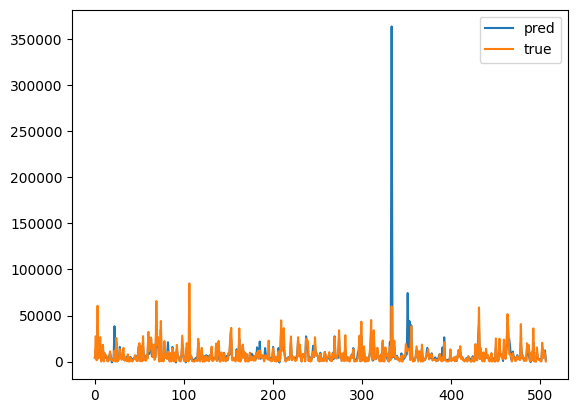

In [ ]:
# 예측력 확인
plt.plot(np.array(model2.predict(X_test)),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

In [ ]:
# 정산인원과 신청인원의 4배이상 차이나는 데이터를 뺀 데이터프레임 (df_out_total)
# 이상치라고 판단해 제외하는 것이 좋지 않을까 생각했는 데, 안 빼는 게 나을 것 같다는 피드백으로 위와의 동일 데이터 사용

In [ ]:
#년도,월 제외 모든 변수 포함 (dummy X)
lr3 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ FCLTY_NM+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO+ISE_ELSE_FLAG_NM', data= train_set)
model3 = lr3.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.661
Model:                              OLS   Adj. R-squared:                  0.660
Method:                   Least Squares   F-statistic:                     572.4
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          4.87e-274
Time:                          11:15:34   Log-Likelihood:                -12708.
No. Observations:                  1180   AIC:                         2.543e+04
Df Residuals:                      1175   BIC:                         2.545e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2724.4092    742.431      3.670      0.000    1267.770    4181.049
FCLTY_NM              -13.7773    114.977     -0.120      0.905    -239.361     211.806
EVENT_SDIV_NM        -732.6262    345.597     -2.120      0.034   -1410.682     -54.570
REQST_EVENT_NMPR_CO     0.6368      0.013     47.336      0.000       0.610       0.663
ISE_ELSE_FLAG_NM     1008.0705   1284.404      0.785      0.433   -1511.911    3528.052
==============================================================================
Omnibus:                      619.678   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6981857.828
Skew:                          -0.294   Prob(JB):                         0.00
Kurtosis:                     379.834   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#년도,월, 내외부 제외 모든 변수 포함 (dummy X)
model4 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ FCLTY_NM+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO', data= train_set).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.699
Method:                   Least Squares   F-statistic:                     114.9
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          1.25e-285
Time:                          11:21:04   Log-Likelihood:                -12626.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1155   BIC:                         2.543e+04
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1589.1655    887.561      1.790      0.074    -152.246    3330.577
C(FCLTY_NM)[T.2]       4143.9520   1164.339      3.559      0.000    1859.496    6428.408
C(FCLTY_NM)[T.3]       1083.0877   1283.458      0.844      0.399   -1435.083    3601.259
C(FCLTY_NM)[T.4]       1581.4756   1301.124      1.215      0.224    -971.355    4134.307
C(FCLTY_NM)[T.5]      -1496.6958   1485.771     -1.007      0.314   -4411.809    1418.417
C(FCLTY_NM)[T.6]       -370.2068   1602.963     -0.231      0.817   -3515.253    2774.839
C(FCLTY_NM)[T.7]      -3011.9568   2446.980     -1.231      0.219   -7812.981    1789.067
C(FCLTY_NM)[T.8]       3303.5437   2132.883      1.549      0.122    -881.215    7488.303
C(FCLTY_NM)[T.9]       -663.2060   2189.280     -0.303      0.762   -4958.618    3632.206
C(FCLTY_NM)[T.10]      -341.7821   2477.251     -0.138      0.890   -5202.199    4518.635
C(FCLTY_NM)[T.11]      1892.0182   3056.246      0.619      0.536   -4104.398    7888.434
C(FCLTY_NM)[T.12]      1385.1387   4100.337      0.338      0.736   -6659.804    9430.081
C(FCLTY_NM)[T.13]      1298.7653   3403.425      0.382      0.703   -5378.822    7976.352
C(FCLTY_NM)[T.14]      3909.5851   3279.629      1.192      0.233   -2525.113    1.03e+04
C(FCLTY_NM)[T.15]     -1.229e+04   3037.901     -4.045      0.000   -1.82e+04   -6327.917
C(FCLTY_NM)[T.16]      1629.9754   5661.659      0.288      0.773   -9478.314    1.27e+04
C(FCLTY_NM)[T.17]      5.693e+04   5349.843     10.641      0.000    4.64e+04    6.74e+04
C(FCLTY_NM)[T.18]      3238.8268   4717.784      0.687      0.493   -6017.560    1.25e+04
C(FCLTY_NM)[T.19]      6043.8980   6553.514      0.922      0.357   -6814.227    1.89e+04
C(FCLTY_NM)[T.20]      1515.6624   6553.053      0.231      0.817   -1.13e+04    1.44e+04
C(EVENT_SDIV_NM)[T.2]  -752.2183    974.492     -0.772      0.440   -2664.191    1159.754
C(EVENT_SDIV_NM)[T.3] -3198.0059   1409.465     -2.269      0.023   -5963.405    -432.607
C(EVENT_SDIV_NM)[T.4] -2745.7279   1750.254     -1.569      0.117   -6179.762     688.306
C(EVENT_SDIV_NM)[T.5]   -53.0106   3214.659     -0.016      0.987   -6360.235    6254.214
REQST_EVENT_NMPR_CO       0.5899      0.014     43.421      0.000       0.563       0.617
==============================================================================
Omnibus:                      636.221   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4426031.142
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                     303.033   Cond. No.                     6.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

In [ ]:
# 표준화 의미 없어서 생략

###### dummy variable O
- 공연장소, 공연유형, 내외부

In [ ]:
#모든 변수 포함 (dummy O)
lr5 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+C(ISE_ELSE_FLAG_NM)+년도+월', data= train_set)
model5 = lr5.fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.698
Method:                   Least Squares   F-statistic:                     106.0
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          8.69e-284
Time:                          11:15:34   Log-Likelihood:                -12625.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1153   BIC:                         2.544e+04
Df Model:                            26                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.666e+05   2.06e+05     -0.808      0.419   -5.71e+05    2.38e+05
C(FCLTY_NM)[T.2]          4312.9332   1177.247      3.664      0.000    2003.146    6622.720
C(FCLTY_NM)[T.3]          1053.7253   1285.249      0.820      0.412   -1467.964    3575.414
C(FCLTY_NM)[T.4]          1615.4716   1302.916      1.240      0.215    -940.880    4171.823
C(FCLTY_NM)[T.5]         -1590.4900   1490.891     -1.067      0.286   -4515.653    1334.673
C(FCLTY_NM)[T.6]          -540.6563   1617.604     -0.334      0.738   -3714.434    2633.121
C(FCLTY_NM)[T.7]         -1.007e+04   1980.726     -5.086      0.000    -1.4e+04   -6188.663
C(FCLTY_NM)[T.8]         -3785.4116   2366.645     -1.599      0.110   -8428.825     858.002
C(FCLTY_NM)[T.9]         -7599.4130   2399.732     -3.167      0.002   -1.23e+04   -2891.081
C(FCLTY_NM)[T.10]         -208.7601   2491.051     -0.084      0.933   -5096.260    4678.740
C(FCLTY_NM)[T.11]         1746.2477   3063.966      0.570      0.569   -4265.326    7757.821
C(FCLTY_NM)[T.12]        -5891.1778   3528.380     -1.670      0.095   -1.28e+04    1031.587
C(FCLTY_NM)[T.13]        -5938.0848   2883.320     -2.059      0.040   -1.16e+04    -280.944
C(FCLTY_NM)[T.14]        -3354.0961   3119.473     -1.075      0.283   -9474.575    2766.383
C(FCLTY_NM)[T.15]        -1.225e+04   3041.458     -4.028      0.000   -1.82e+04   -6283.252
C(FCLTY_NM)[T.16]         1968.7505   5674.527      0.347      0.729   -9164.806    1.31e+04
C(FCLTY_NM)[T.17]         5.025e+04   4723.378     10.638      0.000     4.1e+04    5.95e+04
C(FCLTY_NM)[T.18]         3628.9600   4743.611      0.765      0.444   -5678.116    1.29e+04
C(FCLTY_NM)[T.19]        -1014.7370   5777.896     -0.176      0.861   -1.24e+04    1.03e+04
C(FCLTY_NM)[T.20]        -5538.9377   5775.352     -0.959      0.338   -1.69e+04    5792.438
C(EVENT_SDIV_NM)[T.2]     -598.6623    986.784     -0.607      0.544   -2534.756    1337.431
C(EVENT_SDIV_NM)[T.3]    -3116.8608   1412.396     -2.207      0.028   -5888.016    -345.706
C(EVENT_SDIV_NM)[T.4]    -2599.4658   1762.583     -1.475      0.141   -6057.696     858.764
C(EVENT_SDIV_NM)[T.5]       22.8120   3217.053      0.007      0.994   -6289.121    6334.745
C(ISE_ELSE_FLAG_NM)[T.1]  7050.6551   1776.922      3.968      0.000    3564.292    1.05e+04
REQST_EVENT_NMPR_CO          0.5896      0.014     43.359      0.000       0.563       0.616
년도                          83.1883    102.204      0.814      0.416    -117.339     283.716
월                           62.0704     95.336      0.651      0.515    -124.980     249.121
==============================================================================
Omnibus:                      638.465   Durbin-Watson:                   2.010
Prob(Omnibus):      

In [ ]:
#년도 변수 제외 (dummy O)
lr6 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+C(ISE_ELSE_FLAG_NM)+월', data= train_set)
model6 = lr6.fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.699
Method:                   Least Squares   F-statistic:                     110.3
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          1.14e-284
Time:                          11:15:34   Log-Likelihood:                -12625.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1154   BIC:                         2.543e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1158.7180   1147.961      1.009      0.313   -1093.606    3411.042
C(FCLTY_NM)[T.2]          4188.3287   1167.080      3.589      0.000    1898.491    6478.166
C(FCLTY_NM)[T.3]          1096.0789   1284.008      0.854      0.393   -1423.172    3615.330
C(FCLTY_NM)[T.4]          1615.0204   1302.725      1.240      0.215    -940.955    4170.996
C(FCLTY_NM)[T.5]         -1496.4449   1486.190     -1.007      0.314   -4412.381    1419.491
C(FCLTY_NM)[T.6]          -368.1081   1603.418     -0.230      0.818   -3514.050    2777.834
C(FCLTY_NM)[T.7]         -1.003e+04   1979.774     -5.068      0.000   -1.39e+04   -6148.851
C(FCLTY_NM)[T.8]         -3752.3815   2365.951     -1.586      0.113   -8394.429     889.666
C(FCLTY_NM)[T.9]         -7743.5583   2392.839     -3.236      0.001   -1.24e+04   -3048.756
C(FCLTY_NM)[T.10]         -398.2408   2479.787     -0.161      0.872   -5263.636    4467.155
C(FCLTY_NM)[T.11]         1906.3034   3057.202      0.624      0.533   -4091.994    7904.601
C(FCLTY_NM)[T.12]        -5785.9171   3525.494     -1.641      0.101   -1.27e+04    1131.179
C(FCLTY_NM)[T.13]        -5743.9496   2873.017     -1.999      0.046   -1.14e+04    -107.027
C(FCLTY_NM)[T.14]        -3182.0204   3111.846     -1.023      0.307   -9287.529    2923.488
C(FCLTY_NM)[T.15]        -1.222e+04   3040.812     -4.019      0.000   -1.82e+04   -6256.073
C(FCLTY_NM)[T.16]         1712.9998   5664.993      0.302      0.762   -9401.839    1.28e+04
C(FCLTY_NM)[T.17]         4.997e+04   4710.327     10.608      0.000    4.07e+04    5.92e+04
C(FCLTY_NM)[T.18]         3242.6485   4719.117      0.687      0.492   -6016.362    1.25e+04
C(FCLTY_NM)[T.19]        -1139.3783   5775.021     -0.197      0.844   -1.25e+04    1.02e+04
C(FCLTY_NM)[T.20]        -5537.9121   5774.507     -0.959      0.338   -1.69e+04    5791.796
C(EVENT_SDIV_NM)[T.2]     -698.6047    978.972     -0.714      0.476   -2619.368    1222.159
C(EVENT_SDIV_NM)[T.3]    -3173.8455   1410.454     -2.250      0.025   -5941.186    -406.505
C(EVENT_SDIV_NM)[T.4]    -2762.0935   1750.966     -1.577      0.115   -6197.527     673.340
C(EVENT_SDIV_NM)[T.5]      -40.9442   3215.628     -0.013      0.990   -6350.077    6268.189
C(ISE_ELSE_FLAG_NM)[T.1]  7051.1117   1776.662      3.969      0.000    3565.262    1.05e+04
REQST_EVENT_NMPR_CO          0.5897      0.014     43.375      0.000       0.563       0.616
월                           56.2209     95.051      0.591      0.554    -130.270     242.712
==============================================================================
Omnibus:                      636.942   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4430663.385
Skew:                          -0.

In [ ]:
#년도,월 변수 제외 (dummy O)
lr7 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+C(ISE_ELSE_FLAG_NM)', data= train_set)
model7 = lr7.fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.699
Method:                   Least Squares   F-statistic:                     114.9
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          1.25e-285
Time:                          11:15:35   Log-Likelihood:                -12626.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1155   BIC:                         2.543e+04
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1589.1655    887.561      1.790      0.074    -152.246    3330.577
C(FCLTY_NM)[T.2]          4143.9520   1164.339      3.559      0.000    1859.496    6428.408
C(FCLTY_NM)[T.3]          1083.0877   1283.458      0.844      0.399   -1435.083    3601.259
C(FCLTY_NM)[T.4]          1581.4756   1301.124      1.215      0.224    -971.355    4134.307
C(FCLTY_NM)[T.5]         -1496.6958   1485.771     -1.007      0.314   -4411.809    1418.417
C(FCLTY_NM)[T.6]          -370.2068   1602.963     -0.231      0.817   -3515.253    2774.839
C(FCLTY_NM)[T.7]         -1.008e+04   1977.437     -5.099      0.000    -1.4e+04   -6203.089
C(FCLTY_NM)[T.8]         -3767.3595   2365.150     -1.593      0.111   -8407.831     873.112
C(FCLTY_NM)[T.9]         -7734.1092   2392.112     -3.233      0.001   -1.24e+04   -3040.738
C(FCLTY_NM)[T.10]         -341.7821   2477.251     -0.138      0.890   -5202.199    4518.635
C(FCLTY_NM)[T.11]         1892.0182   3056.246      0.619      0.536   -4104.398    7888.434
C(FCLTY_NM)[T.12]        -5685.7645   3520.434     -1.615      0.107   -1.26e+04    1221.398
C(FCLTY_NM)[T.13]        -5772.1378   2871.814     -2.010      0.045   -1.14e+04    -137.582
C(FCLTY_NM)[T.14]        -3161.3181   3110.773     -1.016      0.310   -9264.717    2942.080
C(FCLTY_NM)[T.15]        -1.229e+04   3037.901     -4.045      0.000   -1.82e+04   -6327.917
C(FCLTY_NM)[T.16]         1629.9754   5661.659      0.288      0.773   -9478.314    1.27e+04
C(FCLTY_NM)[T.17]         4.986e+04   4705.144     10.596      0.000    4.06e+04    5.91e+04
C(FCLTY_NM)[T.18]         3238.8268   4717.784      0.687      0.493   -6017.560    1.25e+04
C(FCLTY_NM)[T.19]        -1027.0052   5770.271     -0.178      0.859   -1.23e+04    1.03e+04
C(FCLTY_NM)[T.20]        -5555.2407   5772.807     -0.962      0.336   -1.69e+04    5771.122
C(EVENT_SDIV_NM)[T.2]     -752.2183    974.492     -0.772      0.440   -2664.191    1159.754
C(EVENT_SDIV_NM)[T.3]    -3198.0059   1409.465     -2.269      0.023   -5963.405    -432.607
C(EVENT_SDIV_NM)[T.4]    -2745.7279   1750.254     -1.569      0.117   -6179.762     688.306
C(EVENT_SDIV_NM)[T.5]      -53.0106   3214.659     -0.016      0.987   -6360.235    6254.214
C(ISE_ELSE_FLAG_NM)[T.1]  7070.9032   1775.847      3.982      0.000    3586.656    1.06e+04
REQST_EVENT_NMPR_CO          0.5899      0.014     43.421      0.000       0.563       0.617
==============================================================================
Omnibus:                      636.221   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4426031.142
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                     303.033   Cond. No

In [ ]:
#년도,월,내외부 변수 제외 (dummy O)
lr8 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO', data= train_set)
model8 = lr8.fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.699
Method:                   Least Squares   F-statistic:                     114.9
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          1.25e-285
Time:                          11:15:35   Log-Likelihood:                -12626.
No. Observations:                  1180   AIC:                         2.530e+04
Df Residuals:                      1155   BIC:                         2.543e+04
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1589.1655    887.561      1.790      0.074    -152.246    3330.577
C(FCLTY_NM)[T.2]       4143.9520   1164.339      3.559      0.000    1859.496    6428.408
C(FCLTY_NM)[T.3]       1083.0877   1283.458      0.844      0.399   -1435.083    3601.259
C(FCLTY_NM)[T.4]       1581.4756   1301.124      1.215      0.224    -971.355    4134.307
C(FCLTY_NM)[T.5]      -1496.6958   1485.771     -1.007      0.314   -4411.809    1418.417
C(FCLTY_NM)[T.6]       -370.2068   1602.963     -0.231      0.817   -3515.253    2774.839
C(FCLTY_NM)[T.7]      -3011.9568   2446.980     -1.231      0.219   -7812.981    1789.067
C(FCLTY_NM)[T.8]       3303.5437   2132.883      1.549      0.122    -881.215    7488.303
C(FCLTY_NM)[T.9]       -663.2060   2189.280     -0.303      0.762   -4958.618    3632.206
C(FCLTY_NM)[T.10]      -341.7821   2477.251     -0.138      0.890   -5202.199    4518.635
C(FCLTY_NM)[T.11]      1892.0182   3056.246      0.619      0.536   -4104.398    7888.434
C(FCLTY_NM)[T.12]      1385.1387   4100.337      0.338      0.736   -6659.804    9430.081
C(FCLTY_NM)[T.13]      1298.7653   3403.425      0.382      0.703   -5378.822    7976.352
C(FCLTY_NM)[T.14]      3909.5851   3279.629      1.192      0.233   -2525.113    1.03e+04
C(FCLTY_NM)[T.15]     -1.229e+04   3037.901     -4.045      0.000   -1.82e+04   -6327.917
C(FCLTY_NM)[T.16]      1629.9754   5661.659      0.288      0.773   -9478.314    1.27e+04
C(FCLTY_NM)[T.17]      5.693e+04   5349.843     10.641      0.000    4.64e+04    6.74e+04
C(FCLTY_NM)[T.18]      3238.8268   4717.784      0.687      0.493   -6017.560    1.25e+04
C(FCLTY_NM)[T.19]      6043.8980   6553.514      0.922      0.357   -6814.227    1.89e+04
C(FCLTY_NM)[T.20]      1515.6624   6553.053      0.231      0.817   -1.13e+04    1.44e+04
C(EVENT_SDIV_NM)[T.2]  -752.2183    974.492     -0.772      0.440   -2664.191    1159.754
C(EVENT_SDIV_NM)[T.3] -3198.0059   1409.465     -2.269      0.023   -5963.405    -432.607
C(EVENT_SDIV_NM)[T.4] -2745.7279   1750.254     -1.569      0.117   -6179.762     688.306
C(EVENT_SDIV_NM)[T.5]   -53.0106   3214.659     -0.016      0.987   -6360.235    6254.214
REQST_EVENT_NMPR_CO       0.5899      0.014     43.421      0.000       0.563       0.617
==============================================================================
Omnibus:                      636.221   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4426031.142
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                     303.033   Cond. No.                     6.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

In [ ]:
# 최종적으로 공연장소, 공연유형은 dummy variable로 취해주고 (공연장소, 공연유형, 신청인원)만이 유의하다고 결론 도출

#### Model 2 (회귀분석)
- 변수: C(공연장소), C(공연유형), 신청인원, vector3_col
- vector3_col: vector3 함수를 이용해 도출한 유사공연의 정산인원

In [ ]:
# 유사공연 1개만 도출
vector3_col= pd.read_csv('/content/drive/MyDrive/DAB/Model /vector3_col.csv')

In [ ]:
vector3_col

,vector3_col
0,2000
1,2000
2,2000
3,2000
4,2000
...,...
1681,7128
1682,7128
1683,6925
1684,9493


In [ ]:
df2_pred = df2.copy()

In [ ]:
df2_pred = df2_pred.iloc[:,[0,1,5,6,8]]
df2_pred

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,USE_DAY_CO
0,8,4,2000,2000,1
1,17,4,300,300,1
2,18,3,1600,1600,2
3,9,1,3500,2395,11
4,14,1,20000,14153,62
...,...,...,...,...,...
1682,5,1,6000,4504,7
1683,3,1,8000,9493,5
1684,2,1,14000,15100,8
1685,7,4,10000,10000,2


In [ ]:
df2_pred = df2_pred.join(vector3_col,how='inner') #1687번째 행은 도출 x

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model_pred1 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM)+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO+USE_DAY_CO+vector3_col',data= df2_pred).fit()
model_pred1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.598
Model:                              OLS   Adj. R-squared:                  0.592
Method:                   Least Squares   F-statistic:                     102.8
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          4.31e-307
Time:                          11:32:37   Log-Likelihood:                -18099.
No. Observations:                  1686   AIC:                         3.625e+04
Df Residuals:                      1661   BIC:                         3.638e+04
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3344.7511    822.837      4.065      0.000    1730.843    4958.659
C(FCLTY_NM)[T.2]     6075.4664    848.208      7.163      0.000    4411.798    7739.135
C(FCLTY_NM)[T.3]      325.8420    842.956      0.387      0.699   -1327.527    1979.211
C(FCLTY_NM)[T.4]     1222.9969   1170.963      1.044      0.296   -1073.722    3519.716
C(FCLTY_NM)[T.5]    -2293.5721   1189.193     -1.929      0.054   -4626.048      38.904
C(FCLTY_NM)[T.6]     -978.5851   1375.943     -0.711      0.477   -3677.350    1720.179
C(FCLTY_NM)[T.7]    -3899.5892   1753.313     -2.224      0.026   -7338.526    -460.652
C(FCLTY_NM)[T.8]     4025.5736   1665.102      2.418      0.016     759.653    7291.494
C(FCLTY_NM)[T.9]     -558.4867   1787.192     -0.312      0.755   -4063.873    2946.899
C(FCLTY_NM)[T.10]   -2310.5151   2145.658     -1.077      0.282   -6518.993    1897.963
C(FCLTY_NM)[T.11]    -429.5191   2550.153     -0.168      0.866   -5431.371    4572.333
C(FCLTY_NM)[T.12]    1452.9358   2800.610      0.519      0.604   -4040.162    6946.034
C(FCLTY_NM)[T.13]     621.0260   2808.341      0.221      0.825   -4887.234    6129.286
C(FCLTY_NM)[T.14]    5573.0996   2847.825      1.957      0.051     -12.605    1.12e+04
C(FCLTY_NM)[T.15]    -1.19e+04   2968.191     -4.009      0.000   -1.77e+04   -6076.841
C(FCLTY_NM)[T.16]    -554.0851   4017.365     -0.138      0.890   -8433.718    7325.548
C(FCLTY_NM)[T.17]    5.644e+04   4413.623     12.787      0.000    4.78e+04    6.51e+04
C(FCLTY_NM)[T.18]    1237.2591   4287.214      0.289      0.773   -7171.654    9646.172
C(FCLTY_NM)[T.19]    4362.1938   5100.230      0.855      0.393   -5641.364    1.44e+04
C(FCLTY_NM)[T.20]     885.4995   6536.221      0.135      0.892   -1.19e+04    1.37e+04
C(FCLTY_NM)[T.21]     395.8577   1.12e+04      0.035      0.972   -2.17e+04    2.24e+04
EVENT_SDIV_NM        -940.5389    352.112     -2.671      0.008   -1631.168    -249.909
REQST_EVENT_NMPR_CO     0.4383      0.011     38.812      0.000       0.416       0.460
USE_DAY_CO             84.7441     22.096      3.835      0.000      41.405     128.083
vector3_col            -0.0176      0.027     -0.640      0.522      -0.071       0.036
==============================================================================
Omnibus:                     2515.113   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10471724.333
Skew:                           7.834   Prob(JB):                         0.00
Kurtosis:                     388.770   Cond. No.                     1.14e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition numbe

In [ ]:
x_cols = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","vector3_col"]

In [ ]:
def makeprediction2(index,df):
  result = model_pred1.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
makeprediction2(2,df2_pred)

2596

In [ ]:
model_pred1.predict(df2_pred[x_cols])

0        4534.448135
1       56199.288541
2        2596.077769
3        4276.965663
4       21963.224514
            ...     
1681     3998.682264
1682     3208.624138
1683     6538.812869
1684    15127.607409
1685      179.376150
Length: 1686, dtype: float64

In [ ]:
pd.DataFrame([df2_pred["EXCCLC_EVENT_NMPR_CO"],model_pred1.predict(df2_pred[x_cols])],index=["EXCCLC_EVENT_NMPR_CO","makeprediction2"]).transpose()

,EXCCLC_EVENT_NMPR_CO,makeprediction2
0,2000.0,4534.448135
1,300.0,56199.288541
2,1600.0,2596.077769
3,2395.0,4276.965663
4,14153.0,21963.224514
...,...,...
1681,3219.0,3998.682264
1682,4504.0,3208.624138
1683,9493.0,6538.812869
1684,15100.0,15127.607409


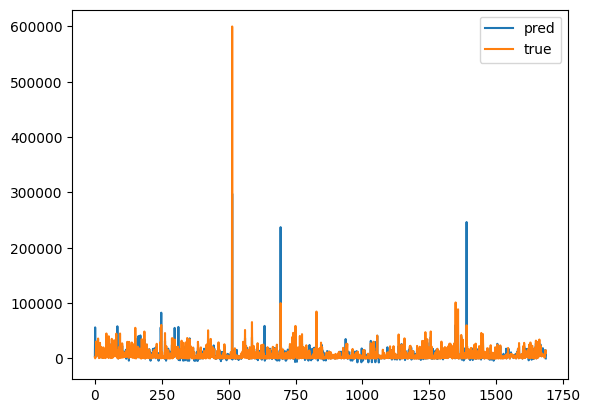

In [ ]:
plt.plot(np.array(model_pred1.predict(df2_pred[x_cols])),label = "pred")
plt.plot(np.array(df2_pred["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(df2_pred["EXCCLC_EVENT_NMPR_CO"], model_pred1.predict(df2_pred[x_cols]))

# makeprediction1의 mse: 496292746911.43994

123533017.68286735

#### Model 2_1 (회귀분석)
- 변수: C(FCLTY_NM_cluster), C(공연유형), 신청인원, vector3_col,
- 공연장소별 정산인원 평균을 내서 군집 4개로 만들고자 함.

공연장소별 정산인원 평균- 3개정도로 줄이기 > makeprediction2 적용해보기

- 공연장소  올림픽홀 (1),KSPO DOME(체조경기장) (2), 핸드볼경기장 (3),우리금융아트홀 (4),뮤즈라이브 (5), K-아트홀 (6), 평화의광장 (7), 88잔디마당 (8), 88호수수변무대 (9), 올림픽컨벤션센터 (10), 핸드볼보조경기장 (11), 기타 (12), 피크닉광장 (13), 한얼광장 (14), 우리금융아트홀 연습실 (15), 벨로드롬 (16), 몽촌해자수변무대A (17), 만남의광장 (19), 몽촌해자수변무대B (20), 촬영 (21)

In [ ]:
df2_pred.groupby(['FCLTY_NM'], as_index=False).mean()["EXCCLC_EVENT_NMPR_CO"].sort_values(ascending = False)

# 10000명, 5000명, 1000명을 기준선으로 적용
# 1 (16,1,7,13)/ 2 (3,6,18,2)/ 3 (0,8,11,17,14,9,19,10,5)/ 4 (12,4,20,15)

16    95294.285714
1     16847.852843
7     13672.294118
13    12923.437500
3      9655.950413
6      7064.321429
18     6824.000000
2      5039.177936
0      4069.770325
8      3585.604651
11     3204.444444
17     2700.000000
14     2685.125000
9      2361.034483
19     1633.333333
10     1631.285714
5      1539.500000
12      474.555556
4       396.438596
20      100.000000
15       57.625000
Name: EXCCLC_EVENT_NMPR_CO, dtype: float64

In [ ]:
df2_pred_new = df2_pred.copy()

In [ ]:
# 1~4 군집 중 어디에 속하는 지
df2_pred_new["FCLTY_NM_cluster"] = 0

In [ ]:
df2_pred_new.loc[(df2_pred_new["FCLTY_NM"]== 16) | (df2_pred_new["FCLTY_NM"]==1) | (df2_pred_new["FCLTY_NM"]==7) | (df2_pred_new["FCLTY_NM"]==13), "FCLTY_NM_cluster"]=1

In [ ]:
df2_pred_new.loc[(df2_pred_new["FCLTY_NM"]== 3) | (df2_pred_new["FCLTY_NM"]==6) | (df2_pred_new["FCLTY_NM"]==18) | (df2_pred_new["FCLTY_NM"]==2),"FCLTY_NM_cluster"] = 2

In [ ]:
# 0,8,11,17,14,9,19,10,5
df2_pred_new.loc[(df2_pred_new["FCLTY_NM"]== 0) | (df2_pred_new["FCLTY_NM"]==8) | (df2_pred_new["FCLTY_NM"]==11) | (df2_pred_new["FCLTY_NM"]==17) | (df2_pred_new["FCLTY_NM"]==14) | (df2_pred_new["FCLTY_NM"]==9) | (df2_pred_new["FCLTY_NM"]==19)| (df2_pred_new["FCLTY_NM"]==10) | (df2_pred_new["FCLTY_NM"]==5),"FCLTY_NM_cluster"] = 3

In [ ]:
df2_pred_new.loc[(df2_pred_new["FCLTY_NM"]== 12) | (df2_pred_new["FCLTY_NM"]==4) | (df2_pred_new["FCLTY_NM"]==20) | (df2_pred_new["FCLTY_NM"]==15),"FCLTY_NM_cluster"] = 4

In [ ]:
df2_pred_new

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,USE_DAY_CO,vector3_col,FCLTY_NM_cluster
0,8,4,2000,2000,1,2000,3
1,17,4,300,300,1,2000,3
2,18,3,1600,1600,2,2000,2
3,9,1,3500,2395,11,2000,3
4,14,1,20000,14153,62,2000,3
...,...,...,...,...,...,...,...
1681,3,1,2600,3219,3,7128,2
1682,5,1,6000,4504,7,7128,3
1683,3,1,8000,9493,5,6925,2
1684,2,1,14000,15100,8,9493,2


In [ ]:
model_pred1_new = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM_cluster)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+vector3_col',data= df2_pred_new).fit()
model_pred1_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.537
Model:                              OLS   Adj. R-squared:                  0.534
Method:                   Least Squares   F-statistic:                     194.4
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          1.16e-271
Time:                          11:40:40   Log-Likelihood:                -18217.
No. Observations:                  1686   AIC:                         3.646e+04
Df Residuals:                      1675   BIC:                         3.652e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 2252.9232    1.2e+04      0.188      0.851   -2.13e+04    2.58e+04
C(FCLTY_NM_cluster)[T.1]  -259.7734    1.2e+04     -0.022      0.983   -2.38e+04    2.33e+04
C(FCLTY_NM_cluster)[T.2]  3266.3096    1.2e+04      0.272      0.786   -2.03e+04    2.68e+04
C(FCLTY_NM_cluster)[T.3]  1508.5924    1.2e+04      0.125      0.900   -2.21e+04    2.51e+04
C(FCLTY_NM_cluster)[T.4]   969.0287    1.2e+04      0.081      0.936   -2.26e+04    2.46e+04
C(EVENT_SDIV_NM)[T.2]    -1032.6451    796.207     -1.297      0.195   -2594.310     529.020
C(EVENT_SDIV_NM)[T.3]    -4191.5453   1075.371     -3.898      0.000   -6300.758   -2082.333
C(EVENT_SDIV_NM)[T.4]    -2199.1235   1080.005     -2.036      0.042   -4317.424     -80.823
C(EVENT_SDIV_NM)[T.5]    -3604.8486   2712.763     -1.329      0.184   -8925.612    1715.915
REQST_EVENT_NMPR_CO          0.4811      0.011     42.123      0.000       0.459       0.503
vector3_col                 -0.0048      0.029     -0.163      0.870      -0.062       0.052
==============================================================================
Omnibus:                     2588.367   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14005323.211
Skew:                           8.252   Prob(JB):                         0.00
Kurtosis:                     449.197   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 50000명,10000명, 5000명, 1000명을 기준선으로 적용
# 1 (16)/ 2 (1,7,13)/ 3 (3,6,18,2)/ 4 (0,8,11,17,14,9,19,10,5)/ 5 (12,4,20,15)

In [ ]:
df2_pred_new2 = df2_pred.copy()

In [ ]:
df2_pred_new2["FCLTY_NM_cluster"] = 0

In [ ]:
df2_pred_new2.loc[(df2_pred_new2["FCLTY_NM"]== 16)]=1

In [ ]:
df2_pred_new2.loc[(df2_pred_new2["FCLTY_NM"]==1) | (df2_pred_new2["FCLTY_NM"]==7) | (df2_pred_new2["FCLTY_NM"]==13), "FCLTY_NM_cluster"]=2

In [ ]:
df2_pred_new2.loc[(df2_pred_new2["FCLTY_NM"]== 3) | (df2_pred_new2["FCLTY_NM"]==6) | (df2_pred_new2["FCLTY_NM"]==18) | (df2_pred_new2["FCLTY_NM"]==2),"FCLTY_NM_cluster"] = 3

In [ ]:
df2_pred_new2.loc[(df2_pred_new2["FCLTY_NM"]== 0) | (df2_pred_new2["FCLTY_NM"]==8) | (df2_pred_new2["FCLTY_NM"]==11) | (df2_pred_new2["FCLTY_NM"]==17) | (df2_pred_new2["FCLTY_NM"]==14) | (df2_pred_new2["FCLTY_NM"]==9) | (df2_pred_new2["FCLTY_NM"]==19)| (df2_pred_new2["FCLTY_NM"]==10) | (df2_pred_new2["FCLTY_NM"]==5),"FCLTY_NM_cluster"] = 4

In [ ]:
df2_pred_new2.loc[(df2_pred_new2["FCLTY_NM"]== 12) | (df2_pred_new2["FCLTY_NM"]==4) | (df2_pred_new2["FCLTY_NM"]==20) | (df2_pred_new2["FCLTY_NM"]==15),"FCLTY_NM_cluster"] = 5

In [ ]:
df2_pred_new2

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,USE_DAY_CO,vector3_col,FCLTY_NM_cluster
0,8,4,2000,2000,1,2000,4
1,17,4,300,300,1,2000,4
2,18,3,1600,1600,2,2000,3
3,9,1,3500,2395,11,2000,4
4,14,1,20000,14153,62,2000,4
...,...,...,...,...,...,...,...
1681,3,1,2600,3219,3,7128,3
1682,5,1,6000,4504,7,7128,4
1683,3,1,8000,9493,5,6925,3
1684,2,1,14000,15100,8,9493,3


In [ ]:
model_pred2_new = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM_cluster)+EVENT_SDIV_NM+REQST_EVENT_NMPR_CO+USE_DAY_CO+vector3_col',data= df2_pred_new2).fit()
model_pred2_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.537
Model:                              OLS   Adj. R-squared:                  0.535
Method:                   Least Squares   F-statistic:                     243.2
Date:                  Sun, 03 Sep 2023   Prob (F-statistic):          5.30e-274
Time:                          11:40:41   Log-Likelihood:                -18218.
No. Observations:                  1686   AIC:                         3.645e+04
Df Residuals:                      1677   BIC:                         3.650e+04
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 4037.8389    1.2e+04      0.336      0.737   -1.95e+04    2.76e+04
C(FCLTY_NM_cluster)[T.2] -1170.0903    1.2e+04     -0.098      0.922   -2.47e+04    2.23e+04
C(FCLTY_NM_cluster)[T.3]  1869.3790    1.2e+04      0.156      0.876   -2.16e+04    2.54e+04
C(FCLTY_NM_cluster)[T.4]   443.5127    1.2e+04      0.037      0.971   -2.31e+04     2.4e+04
C(FCLTY_NM_cluster)[T.5]  -628.3416    1.2e+04     -0.052      0.958   -2.42e+04    2.29e+04
EVENT_SDIV_NM            -1008.4024    292.349     -3.449      0.001   -1581.810    -434.995
REQST_EVENT_NMPR_CO          0.4801      0.011     42.021      0.000       0.458       0.503
USE_DAY_CO                  51.6548     22.898      2.256      0.024       6.744      96.566
vector3_col                 -0.0097      0.029     -0.333      0.739      -0.067       0.048
==============================================================================
Omnibus:                     2615.016   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14242578.037
Skew:                           8.440   Prob(JB):                         0.00
Kurtosis:                     452.952   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 공연장소에 대한 군집 개수를 줄이고자 하니 예측력이 너무 떨어짐.

#### Model 3 (ANN)
- 변수:  C(공연장소), C(공연유형), 신청인원, vector3_col

In [ ]:
df2_pred

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,USE_DAY_CO,vector3_col
0,8,4,2000,2000,1,2000
1,17,4,300,300,1,2000
2,18,3,1600,1600,2,2000
3,9,1,3500,2395,11,2000
4,14,1,20000,14153,62,2000
...,...,...,...,...,...,...
1681,3,1,2600,3219,3,7128
1682,5,1,6000,4504,7,7128
1683,3,1,8000,9493,5,6925
1684,2,1,14000,15100,8,9493


In [ ]:
# df2_pred
X_1 = df2_pred.iloc[:,[0,1,2,5]].values
y_1 = df2_pred["EXCCLC_EVENT_NMPR_CO"].values

In [ ]:
# 8:2로 test train set 나누기
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1,y_train1, test_size = 0.2, shuffle=True)

Buiding ANN

In [ ]:
import tensorflow as tf

In [ ]:
ann1 = tf.keras.models.Sequential()

In [ ]:
ann1.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=6, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann1.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

In [ ]:
model_ann1 = ann1.fit(X_train1, y_train1, batch_size = 32, epochs = 25,validation_data=(X_val1, y_val1), shuffle=True)

Epoch 1/25
34/34 [==============================] - 3s 18ms/step - loss: 319589504.0000 - mean_squared_logarithmic_error: 2.2263 - val_loss: 138608896.0000 - val_mean_squared_logarithmic_error: 2.3446
Epoch 2/25
34/34 [==============================] - 0s 7ms/step - loss: 296188704.0000 - mean_squared_logarithmic_error: 1.8916 - val_loss: 129598848.0000 - val_mean_squared_logarithmic_error: 2.0055
Epoch 3/25
34/34 [==============================] - 0s 6ms/step - loss: 275222688.0000 - mean_squared_logarithmic_error: 1.6264 - val_loss: 125960544.0000 - val_mean_squared_logarithmic_error: 1.7044
Epoch 4/25
34/34 [==============================] - 0s 6ms/step - loss: 256746432.0000 - mean_squared_logarithmic_error: 1.3711 - val_loss: 126747920.0000 - val_mean_squared_logarithmic_error: 1.4072
Epoch 5/25
34/34 [==============================] - 0s 7ms/step - loss: 240568576.0000 - mean_squared_logarithmic_error: 1.1434 - val_loss: 131594024.0000 - val_mean_squared_logarithmic_error: 1.1673

In [ ]:
# test set으로 예측 평가

y_pred1 = ann1.predict(X_test1)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_test1.reshape(len(y_test1),1)),1))

11/11 [==============================] - 0s 2ms/step
[[1.41e+04 1.18e+04]
 [6.74e+02 1.05e+03]
 [1.31e+03 2.00e+03]
 [7.00e+03 1.16e+04]
 [1.92e+02 1.35e+02]
 [7.89e+03 1.20e+04]
 [1.93e+04 2.25e+04]
 [1.04e+03 3.30e+03]
 [7.10e+02 8.00e+02]
 [2.64e+03 3.68e+03]
 [8.89e+02 9.00e+02]
 [1.58e+02 1.00e+02]
 [1.17e+04 1.89e+04]
 [3.61e+03 3.00e+03]
 [6.99e+03 5.51e+03]
 [2.41e+03 1.50e+03]
 [2.64e+03 8.31e+03]
 [1.77e+03 3.28e+03]
 [4.39e+03 2.78e+03]
 [1.99e+02 3.50e+02]
 [5.78e+03 7.44e+03]
 [6.07e+03 9.04e+03]
 [7.90e+02 3.30e+03]
 [6.56e+03 7.65e+03]
 [2.33e+04 3.02e+04]
 [3.23e+04 4.48e+04]
 [1.76e+02 1.10e+02]
 [4.22e+03 4.30e+03]
 [4.05e+03 3.58e+03]
 [3.42e+03 4.49e+03]
 [5.56e+03 8.20e+03]
 [5.02e+02 4.00e+02]
 [2.66e+02 2.50e+02]
 [2.26e+02 1.62e+02]
 [1.06e+04 1.70e+04]
 [3.85e+02 1.10e+03]
 [1.86e+03 1.70e+03]
 [1.54e+02 1.50e+02]
 [6.59e+03 6.94e+03]
 [5.86e+03 2.80e+03]
 [5.28e+03 6.80e+03]
 [5.99e+03 5.72e+03]
 [5.24e+03 3.93e+03]
 [1.61e+04 1.84e+04]
 [9.78e+02 8.00e+02]
 [

In [ ]:
import sklearn.metrics

evs_no=sklearn.metrics.explained_variance_score(y_test1,ann1.predict(X_test1))
mse_no=sklearn.metrics.mean_squared_error(y_test1,ann1.predict(X_test1))
msle_no=sklearn.metrics.mean_squared_log_error(y_test1,ann1.predict(X_test1))
r2_no=sklearn.metrics.r2_score(y_test1,ann1.predict(X_test1))

11/11 [==============================] - 0s 2ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('R2 Score                :',r2_no)

Explained Variance Score: 0.7313841279136811
Mean Square Error       : 21956005.58449393
Mean Squared Log Error  : 0.3851996800494368
R2 Score                : 0.7193725424843584


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


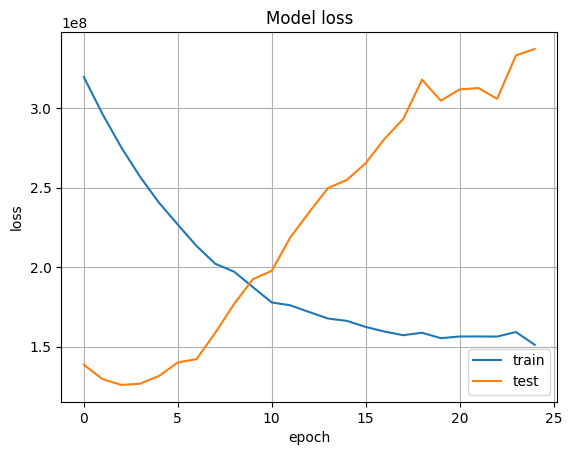

In [ ]:
# list all data in history
print(model_ann1.history.keys())
plt.plot(model_ann1.history['loss'])
plt.plot(model_ann1.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

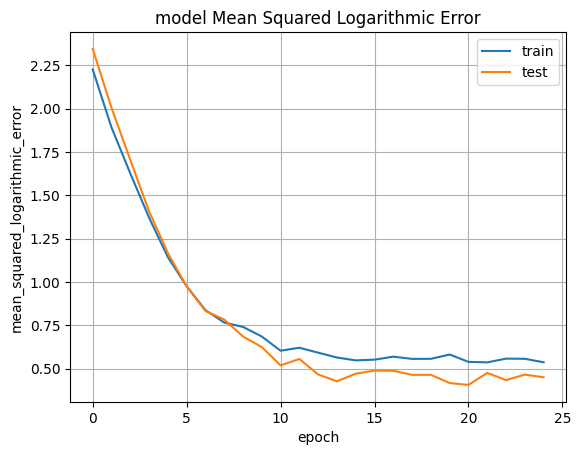

In [ ]:
# summarize history for loss
plt.plot(model_ann1.history['mean_squared_logarithmic_error'])
plt.plot(model_ann1.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
pd.concat([pd.DataFrame(y_pred1),pd.DataFrame(y_test1)],axis=1)

,0,0
0,14089.956055,11764
1,673.904236,1050
2,1310.010742,2000
3,7000.938965,11607
4,191.645538,135
...,...,...
333,355.504333,268
334,1015.541626,1150
335,17845.925781,17554
336,4895.570312,3820


#### 성능지표

 인터뷰 "예측인원이 실제 인원의 10% 오차 범위에 있다면 사용할 것 같다"에 기반하여 지표 생성하고자 함.

(1) 선형회귀모델
(2) ANN 모델
: 몇 퍼센트의 성공률을 보이는지

In [ ]:
# model1(평균)의 mse: 496292746911.43994
# model2(회귀분석)의 mse: 123533017.68286735
# model3(ANN)의 mse:21956005.58449393

In [ ]:
mean_pred = pd.read_csv('/content/drive/MyDrive/DAB/Model /mean_pred.csv', encoding = 'cp949')

In [ ]:
score1_df = pd.concat([pd.DataFrame(df2["EXCCLC_EVENT_NMPR_CO"].iloc[:1686,]),mean_pred],axis=1)
score1_df.columns = ["EXCCLC_EVENT_NMPR_CO","mean_predict"]

In [ ]:
score1_df

,EXCCLC_EVENT_NMPR_CO,mean_predict
0,2000,2000.00
1,300,1150.00
2,1600,1300.00
3,2395,1573.75
4,14153,1573.75
...,...,...
1681,3219,4396.20
1682,4504,5060.60
1683,9493,10036.20
1684,15100,5780.00


In [ ]:
score2_df = pd.DataFrame([df2_pred["EXCCLC_EVENT_NMPR_CO"],model_pred1.predict(df2_pred[x_cols])],index=["EXCCLC_EVENT_NMPR_CO","makeprediction2"]).transpose()

In [ ]:
score2_df

,EXCCLC_EVENT_NMPR_CO,makeprediction2
0,2000.0,4534.448135
1,300.0,56199.288541
2,1600.0,2596.077769
3,2395.0,4276.965663
4,14153.0,21963.224514
...,...,...
1681,3219.0,3998.682264
1682,4504.0,3208.624138
1683,9493.0,6538.812869
1684,15100.0,15127.607409


In [ ]:
score3_df = pd.concat([pd.DataFrame(y_pred1),pd.DataFrame(y_test1)],axis=1)
score3_df.columns = ["test","predict"]

In [ ]:
score3_df

,test,predict
0,14089.956055,11764
1,673.904236,1050
2,1310.010742,2000
3,7000.938965,11607
4,191.645538,135
...,...,...
333,355.504333,268
334,1015.541626,1150
335,17845.925781,17554
336,4895.570312,3820


오차범위계산 함수 (예측 인원이 실제 인원의 10% 오차 범위에 있는지 여부)

In [ ]:
def Error_fun(df,real, predict):
  df["pre_success"] = (df[predict] >= df[real]*0.9) & (df[predict] <= df[real]*1.1)
  return len(df.loc[df["pre_success"] == True])/len(df) # 예측 퍼센트 도출

In [ ]:
Error_fun(score1_df,"EXCCLC_EVENT_NMPR_CO","mean_predict")

0.04863582443653618

In [ ]:
Error_fun(score2_df,"EXCCLC_EVENT_NMPR_CO","makeprediction2")

0.14412811387900357

In [ ]:
Error_fun(score3_df,"test","predict")

0.1804733727810651